X.9.2 Система Ван-дер-Поля и траектория-утки

Рассмотрим неавтономную систему уравнений Ван-дер-Поля:

$$
\begin{cases}
    y'_1 = a \left(-\frac{y_1^3}{3} + y_1 + y_2 \right) \\
    y'_2 = -y_1 + A \cos \omega t
\end{cases}
$$

Начальные условия: $a = 10^3$ и $a = 10^6$, $y_1 = 2$, $y_2 = 0$.
Рассмотреть численно случаи $0 < A < 1$ и $1 < A < \sqrt{1 + \frac{1}{64 \omega^2}}$ 

Найти решение на отрезке $t \in [0, T_k]$, где $T_k = 200$ 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sympy as sp
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation

In [3]:
def f(t, y, params):
    return np.array([params[0] * (- y[0] ** 3 / 3 + y[0] + y[1]), 
                     -y[0] + params[1] * np.cos(params[2] * t)])

def J(y, params):
    return np.matrix([[params[0] * (1 - y[0] ** 2), params[0]], [-1., 0.]])

Воспользуемся неявным методом Адамса 4-порядка:

$$
y_{n+4} = y_{n+3} + h \left(\frac{251}{720} f(t_{n+4}, y_{n+4}) + \frac{646}{720} f(t_{n+3}, y_{n+3}) - \frac{264}{720} f(t_{n+2}, y_{n+2}) + \frac{106}{720} f(t_{n+1}, y_{n+1}) - \frac{19}{720} f(t_n, y_n) \right)
$$

Начальные точки найдём с помощью классического метода Рунге-Кутты 4-порядка.

In [10]:
def RungeKutta4(h, a, b, y_0, f, params):
    x = np.linspace(a, b, int((b - a) / h + 1))
    res = np.zeros(shape = (len(x), len(y_0)))

    res[0] = y_0

    for i in range(len(x) - 1):
        f_1 = f(x[i]            , res[i]                  , params)
        f_2 = f(x[i] + 1 / 2 * h, res[i] + 1 / 2 * h * f_1, params)
        f_3 = f(x[i] + 1 / 2 * h, res[i] + 1 / 2 * h * f_2, params)
        f_4 = f(x[i] +         h, res[i] +         h * f_3, params)

        res[i + 1] = res[i] + h * (1 / 6 * f_1 + 
                                   2 / 6 * f_2 + 
                                   2 / 6 * f_3 + 
                                   1 / 6 * f_4)
        
    return res

def ImplicitAdams4(h, a, b, y_0, f, J, params, eps):
    k = int((b - a) / h + 1)

    if (k < 5): 
        return np.array([])

    x = np.linspace(a, b, k)
    res = np.zeros(shape = (len(x), len(y_0)))

    init_cond = RungeKutta4(h, a, b, y_0, f, params)

    res[0] = init_cond[0]
    res[1] = init_cond[1]
    res[2] = init_cond[2]
    res[3] = init_cond[3]

    for i in range(len(x) - 4):
        f_0 = f(x[i]    , res[i]    , params)
        f_1 = f(x[i + 1], res[i + 1], params)
        f_2 = f(x[i + 2], res[i + 2], params)
        f_3 = f(x[i + 3], res[i + 3], params)

        N = 0

        while (True):
            x_0 = res[i + 4]
            F = h * 251 / 720 * f(x[i + 4], res[i + 4], params) - res[i + 4] + res[i + 3] + h * (+ 646 / 720 * f_3 
                                                                                                 - 264 / 720 * f_2 
                                                                                                 + 106 / 720 * f_1 
                                                                                                 -  19 / 720 * f_0)
            
            J_1 = h * 251 / 720 * J(res[i + 4], params) - np.matrix([[1, 0], [0, 1]])
            res[i + 4] = res[i + 4] - np.linalg.inv(J_1).dot(F)

            N += 1

            if (np.linalg.norm(res[i + 4] - x_0, ord = 2) < eps): 
                break
            if (N > 10):
                break
    return res

In [28]:
h = 10 ** -4
y_0 = np.array([2, 0])
T_k = 200
a = 10 ** 3
A = 0.5
omega = 1

params = [a, A, omega]

a = 0
b = T_k

t = np.linspace(a, b, int((b - a) / h + 1))

x = ImplicitAdams4(h, a, b, y_0, f, J, params, 10 ** -5)

u0 = np.zeros(len(x))
u1 = np.zeros(len(x))

for i in range(len(x)):
    u0[i] = x[i][0]
    u1[i] = x[i][1]

print(u0, u1)

[2.         1.94217951 1.89838553 ... 2.07260361 2.07250193 2.07240024] [ 0.         -0.00014697 -0.0002889  ... -0.14038407 -0.14056698
 -0.14074986]


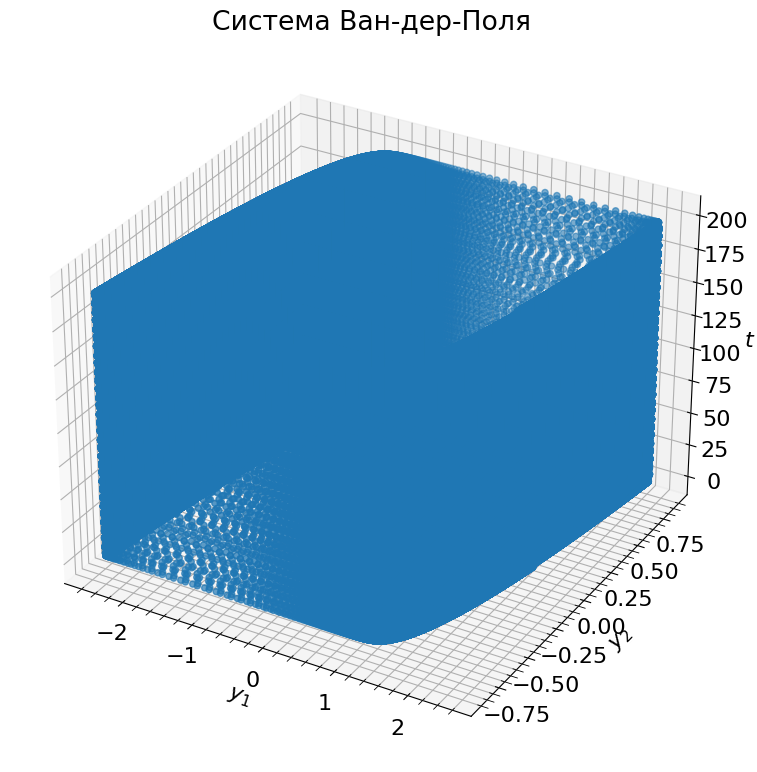

In [29]:
mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта 
plt.figure(figsize = (8,8)) # Создаем фигуру
plt.tight_layout()
ax = plt.axes(projection = '3d')

# Подписываем оси и график
ax.set_title(r"Система Ван-дер-Поля")
ax.set_xlabel(r"$y_1$")
ax.set_ylabel(r"$y_2$")
ax.set_zlabel(r"$t$");

ax.scatter3D(u0, u1, t)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

ax.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
ax.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

ax.minorticks_on()
plt.show()

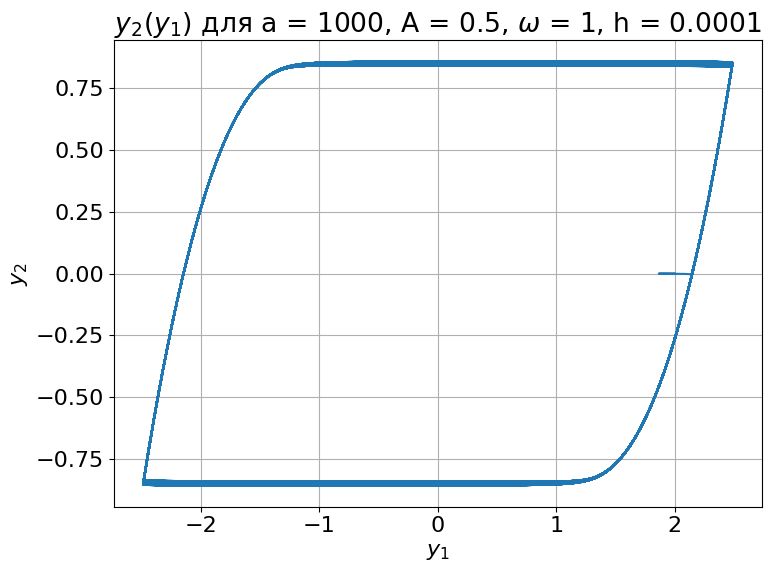

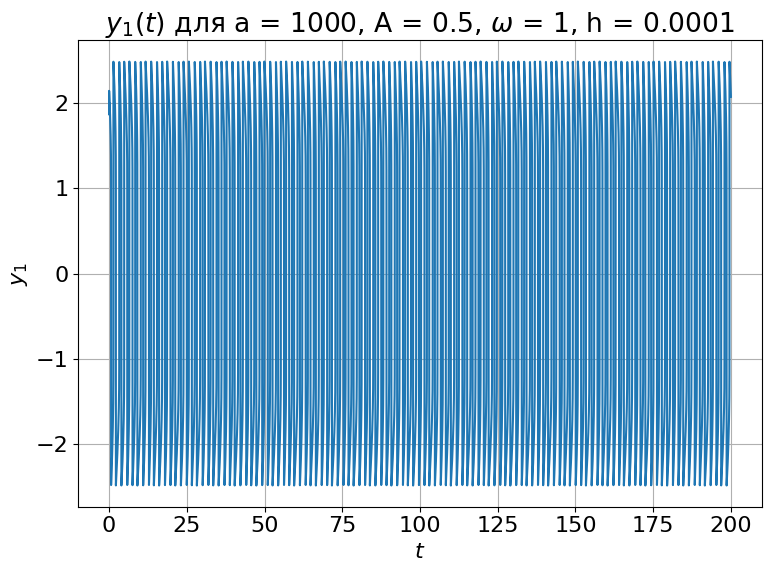

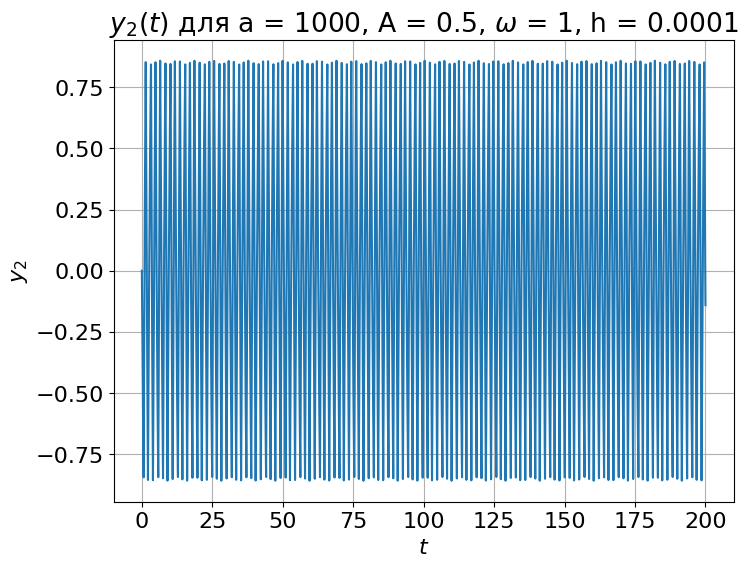

In [30]:
mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта 

plt.figure(figsize=[8, 6])
plt.plot(u0, u1)
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.title(r"$y_2(y_1)$ для a = {}, A = {}, $\omega$ = {}, h = {}".format(*params, h))
plt.tight_layout()
plt.grid()

plt.figure(figsize=[8, 6])
plt.plot(t, u0)
plt.xlabel(r"$t$")
plt.ylabel(r"$y_1$")
plt.title(r"$y_1(t)$ для a = {}, A = {}, $\omega$ = {}, h = {}".format(*params, h))
plt.tight_layout()
plt.grid()

plt.figure(figsize=[8, 6])
plt.plot(t, u1)
plt.xlabel(r"$t$")
plt.ylabel(r"$y_2$")
plt.title(r"$y_2(t)$ для a = {}, A = {}, $\omega$ = {}, h = {}".format(*params, h))
plt.tight_layout()
plt.grid()

In [31]:
h = 10 ** -5
y_0 = np.array([2, 0])
T_k = 200
a = 10 ** 3
A = 5
omega = 0.01

params = [a, A, omega]

a = 0
b = T_k

t = np.linspace(a, b, int((b - a) / h + 1))

x = ImplicitAdams4(h, a, b, y_0, f, J, params, 10 ** -5)

u0 = np.zeros(len(x))
u1 = np.zeros(len(x))

for i in range(len(x)):
    u0[i] = x[i][0]
    u1[i] = x[i][1]

print(u0, u1)

[ 2.          1.9934322   1.98705714 ... -2.01294514 -2.01294555
 -2.01294597] [0.00000000e+00 3.00330027e-05 6.01307136e-05 ... 2.41918979e-01
 2.41918301e-01 2.41917623e-01]


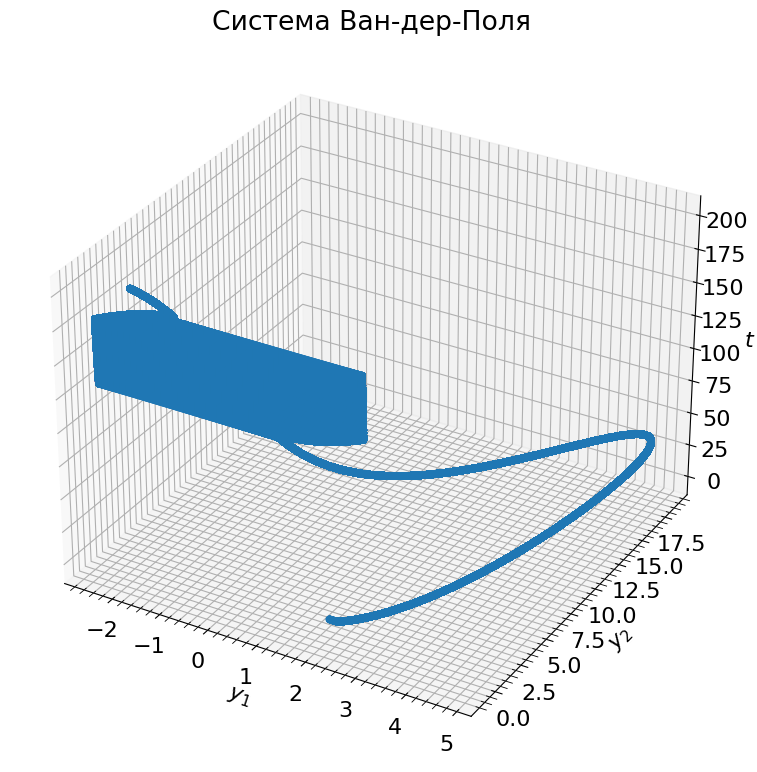

In [32]:
mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта 
plt.figure(figsize = (8,8)) # Создаем фигуру
plt.tight_layout()
ax = plt.axes(projection = '3d')

# Подписываем оси и график
ax.set_title(r"Система Ван-дер-Поля")
ax.set_xlabel(r"$y_1$")
ax.set_ylabel(r"$y_2$")
ax.set_zlabel(r"$t$");

ax.scatter3D(u0, u1, t)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

ax.grid(visible = True, which = 'major', axis = 'both', alpha = 1, linewidth = 0.9)   # Активируем сетку
ax.grid(visible = True, which = 'minor', axis = 'both', alpha = 0.5, linestyle = ':')

ax.minorticks_on()
plt.show()

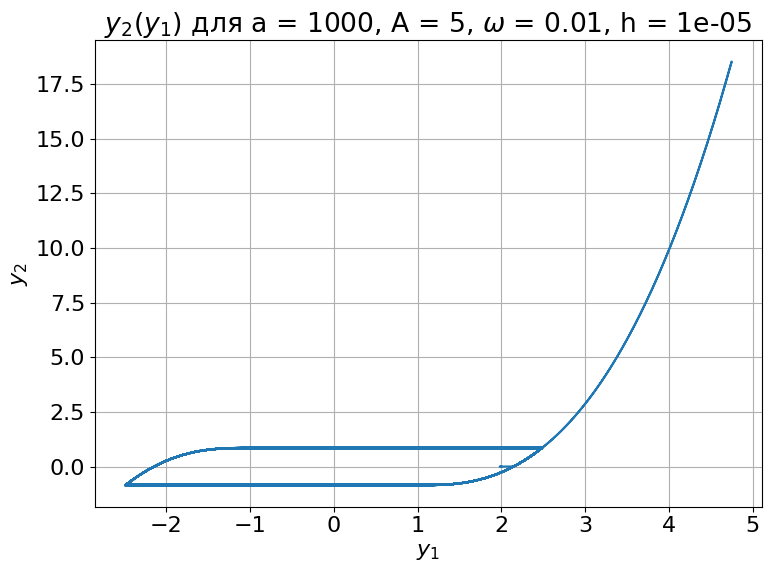

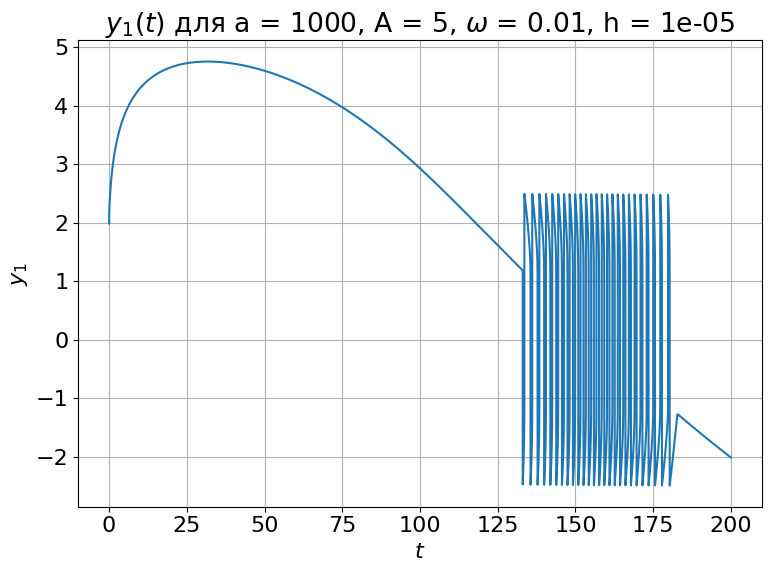

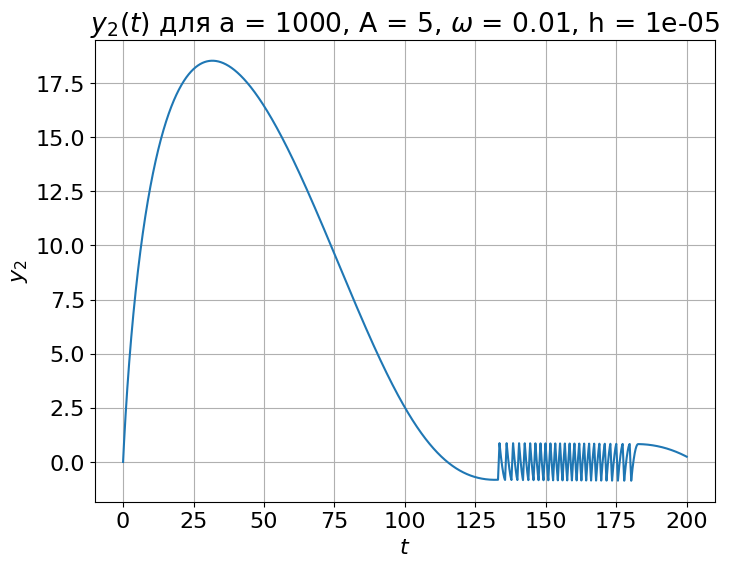

In [33]:
mpl.rcParams['font.size'] = 16                   # Управление стилем, в данном случаем - размером шрифта 

plt.figure(figsize=[8, 6])
plt.plot(u0, u1)
plt.xlabel(r"$y_1$")
plt.ylabel(r"$y_2$")
plt.title(r"$y_2(y_1)$ для a = {}, A = {}, $\omega$ = {}, h = {}".format(*params, h))
plt.tight_layout()
plt.grid()

plt.figure(figsize=[8, 6])
plt.plot(t, u0)
plt.xlabel(r"$t$")
plt.ylabel(r"$y_1$")
plt.title(r"$y_1(t)$ для a = {}, A = {}, $\omega$ = {}, h = {}".format(*params, h))
plt.tight_layout()
plt.grid()

plt.figure(figsize=[8, 6])
plt.plot(t, u1)
plt.xlabel(r"$t$")
plt.ylabel(r"$y_2$")
plt.title(r"$y_2(t)$ для a = {}, A = {}, $\omega$ = {}, h = {}".format(*params, h))
plt.grid()